# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

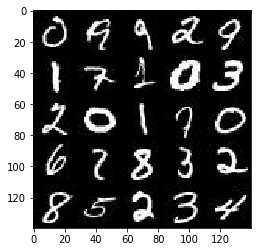

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

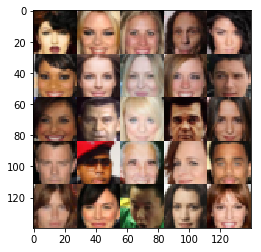

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Leaky factor for leaky ReLU
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64

        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Leaky factor for leaky ReLU
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # Input z
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x512 now

        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding="same", kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)        
        # 16x16x128 now

        x4 = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 32x32x3 now

        logits = tf.image.resize_images(x4, [28, 28])
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Smoothing
    smooth = 0.1

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    print_every = 10
    show_every = 100
    
    _, image_width, image_height, channels = data_shape

    input_real, input_z, lr = model_inputs(image_width, image_height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Rescale images
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                # Print losses
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # Print generator output
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4124... Generator Loss: 2.8248
Epoch 1/2... Discriminator Loss: 0.4838... Generator Loss: 2.7294
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 0.7137... Generator Loss: 8.2052
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 2.3040
Epoch 1/2... Discriminator Loss: 0.5268... Generator Loss: 2.5828
Epoch 1/2... Discriminator Loss: 0.7439... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 1.4441
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 1.1446
Epoch 1/2... Discriminator Loss: 0.5754... Generator Loss: 2.3710


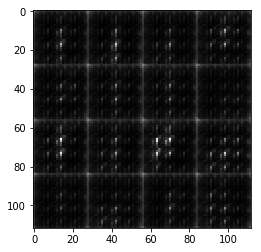

Epoch 1/2... Discriminator Loss: 0.9760... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 0.6088... Generator Loss: 1.9429
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.2076
Epoch 1/2... Discriminator Loss: 0.8487... Generator Loss: 1.1926
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 1.0229
Epoch 1/2... Discriminator Loss: 0.7458... Generator Loss: 1.4516
Epoch 1/2... Discriminator Loss: 0.7412... Generator Loss: 2.6502
Epoch 1/2... Discriminator Loss: 0.6454... Generator Loss: 2.3104
Epoch 1/2... Discriminator Loss: 0.7412... Generator Loss: 2.1049
Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 2.1324


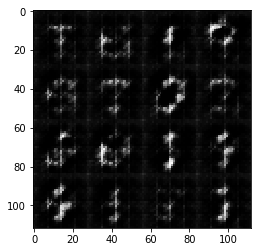

Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.4860
Epoch 1/2... Discriminator Loss: 0.8677... Generator Loss: 1.2625
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 2.3652
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 1.1990
Epoch 1/2... Discriminator Loss: 1.0242... Generator Loss: 2.6800
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 0.6868... Generator Loss: 1.8899
Epoch 1/2... Discriminator Loss: 0.8507... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 0.6282... Generator Loss: 1.9121
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 2.3995


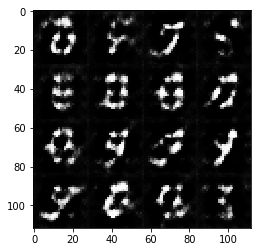

Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 2.2266
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 1.2514
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 0.6755... Generator Loss: 1.8587
Epoch 1/2... Discriminator Loss: 0.6874... Generator Loss: 1.6845
Epoch 1/2... Discriminator Loss: 0.8512... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 0.7054... Generator Loss: 1.7109
Epoch 1/2... Discriminator Loss: 1.3148... Generator Loss: 3.2677
Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 1.8804
Epoch 1/2... Discriminator Loss: 1.0990... Generator Loss: 0.7955


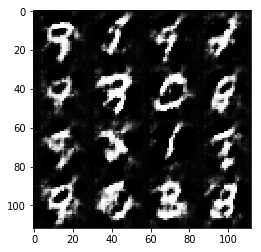

Epoch 1/2... Discriminator Loss: 0.8813... Generator Loss: 1.1247
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 0.9788... Generator Loss: 1.4373
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.2741
Epoch 1/2... Discriminator Loss: 0.8601... Generator Loss: 1.4716
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.8171
Epoch 1/2... Discriminator Loss: 0.8666... Generator Loss: 2.1063
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.8240
Epoch 1/2... Discriminator Loss: 1.0091... Generator Loss: 0.8672
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 2.2789


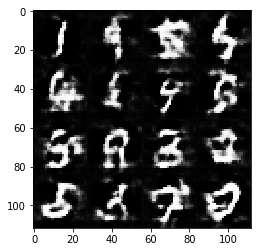

Epoch 1/2... Discriminator Loss: 0.8795... Generator Loss: 1.3159
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 2.3867
Epoch 1/2... Discriminator Loss: 1.2046... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 0.8550... Generator Loss: 1.6256
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 2.2121
Epoch 1/2... Discriminator Loss: 1.1948... Generator Loss: 2.2333
Epoch 1/2... Discriminator Loss: 0.9834... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.0366... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 0.8602


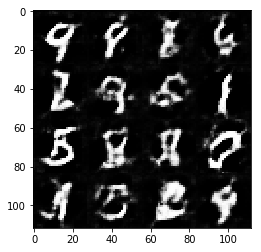

Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.2960
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.2478
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 0.9501... Generator Loss: 1.2105
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 2.1522
Epoch 1/2... Discriminator Loss: 0.8517... Generator Loss: 1.6257
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.4890
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.8498
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 1.2531


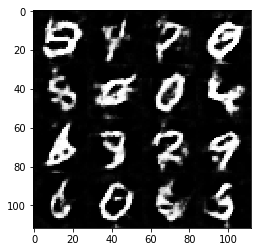

Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.8634
Epoch 1/2... Discriminator Loss: 0.9456... Generator Loss: 1.3989
Epoch 1/2... Discriminator Loss: 1.1265... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 0.9244... Generator Loss: 1.2983
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 0.7514
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 1.2427
Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 2.0931
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.4721
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 1.2691
Epoch 1/2... Discriminator Loss: 0.9579... Generator Loss: 1.0312


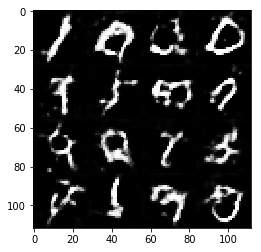

Epoch 1/2... Discriminator Loss: 0.8319... Generator Loss: 1.6839
Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 0.9167
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.3590
Epoch 1/2... Discriminator Loss: 0.8347... Generator Loss: 1.4445
Epoch 1/2... Discriminator Loss: 1.3175... Generator Loss: 0.5681
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 0.6284
Epoch 1/2... Discriminator Loss: 0.8472... Generator Loss: 1.2561
Epoch 1/2... Discriminator Loss: 0.9232... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.5271


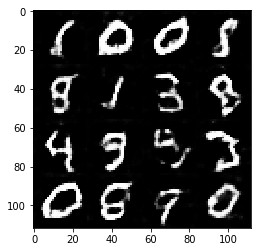

Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 1.7837
Epoch 1/2... Discriminator Loss: 0.8699... Generator Loss: 1.7550
Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.2384
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 2.0837
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.5291
Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 1.2894
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 2.8175
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.1914
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 1.2436


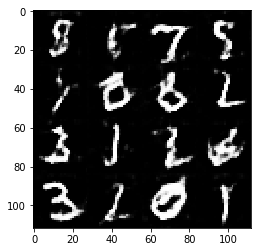

Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.6088
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 0.8860... Generator Loss: 1.1106
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.3048
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.9374
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 0.8571
Epoch 2/2... Discriminator Loss: 0.7932... Generator Loss: 1.3416
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 1.9440
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.8902
Epoch 2/2... Discriminator Loss: 0.8780... Generator Loss: 1.6557


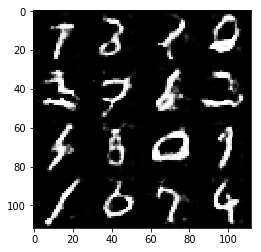

Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 1.2338
Epoch 2/2... Discriminator Loss: 0.8075... Generator Loss: 1.3993
Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 0.9467
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 1.2260... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 1.3980
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.2589
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 0.7641
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.1239
Epoch 2/2... Discriminator Loss: 1.0445... Generator Loss: 0.7797


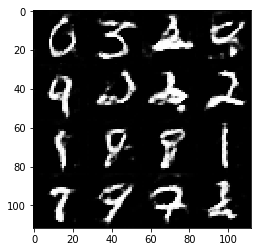

Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 1.2558
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 1.3550
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 0.8385
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 1.2860
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.8192
Epoch 2/2... Discriminator Loss: 2.1141... Generator Loss: 0.2794
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.4394
Epoch 2/2... Discriminator Loss: 0.8608... Generator Loss: 1.0651


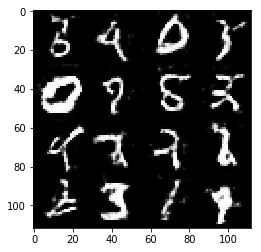

Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 1.3628
Epoch 2/2... Discriminator Loss: 0.9043... Generator Loss: 1.2296
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 1.8384
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.4218
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 1.8410
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 1.0615
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 3.0267


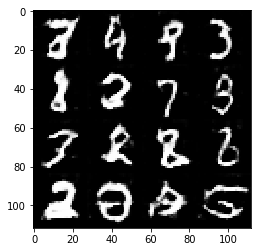

Epoch 2/2... Discriminator Loss: 1.0122... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 0.8908... Generator Loss: 1.0674
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 1.7483
Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 0.8822
Epoch 2/2... Discriminator Loss: 0.7826... Generator Loss: 1.4541
Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 1.3454
Epoch 2/2... Discriminator Loss: 0.9388... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 1.5383
Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 2.1601
Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 1.1974


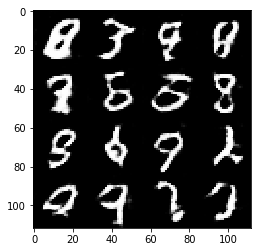

Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.7265
Epoch 2/2... Discriminator Loss: 0.9304... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.1052
Epoch 2/2... Discriminator Loss: 0.8740... Generator Loss: 2.0358
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.0211... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 0.7122... Generator Loss: 1.6454
Epoch 2/2... Discriminator Loss: 0.8719... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 0.9317... Generator Loss: 0.9784
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.7528


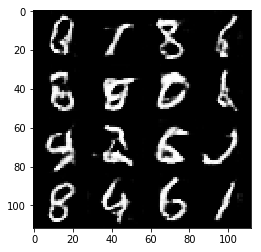

Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.3166
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 2.7470
Epoch 2/2... Discriminator Loss: 0.9613... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 1.3136
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 0.8056... Generator Loss: 2.1175
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.6491
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.7203
Epoch 2/2... Discriminator Loss: 0.7812... Generator Loss: 1.3386


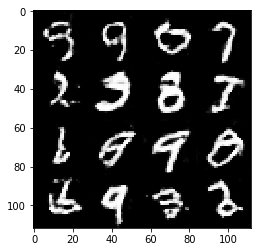

Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.2885
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 0.9778
Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 0.9908
Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 1.9735
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 2.0633
Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 1.6585
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.4987
Epoch 2/2... Discriminator Loss: 0.7707... Generator Loss: 1.3834
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.2627
Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.2811


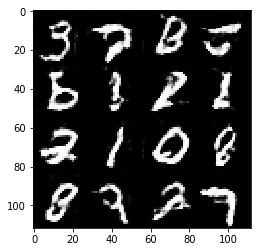

Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.2921
Epoch 2/2... Discriminator Loss: 0.9062... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 0.9713
Epoch 2/2... Discriminator Loss: 0.8170... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.8206
Epoch 2/2... Discriminator Loss: 0.6936... Generator Loss: 1.6377
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.1609


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 3.5122
Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 2.4198
Epoch 1/1... Discriminator Loss: 0.4039... Generator Loss: 3.8427
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 3.2422
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 12.3521
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 7.2228
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 2.0381
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 1.0069
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.7694


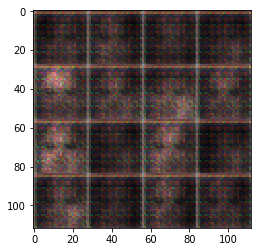

Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 2.8066
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.5447
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.8341
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.0782


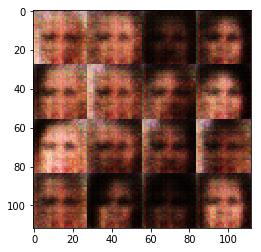

Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 1.9636
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.3214
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 1.9059


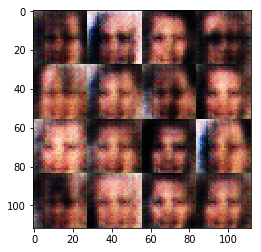

Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.9667
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 1.5555
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 1.6191
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.5450


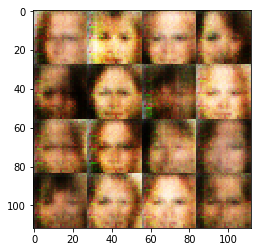

Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.7847
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.6276
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.2807
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.9395
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.3177


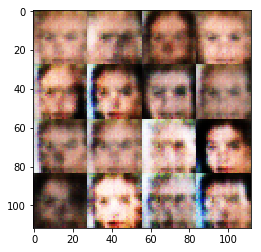

Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.1248
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5392
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.3951
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.5121... Generator Loss: 0.5573
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.9658


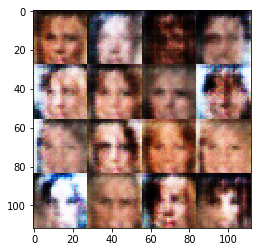

Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.3770
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.8953
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 1.2092


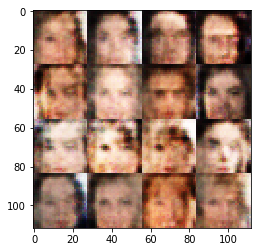

Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.1660
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.2321... Generator Loss: 0.9504


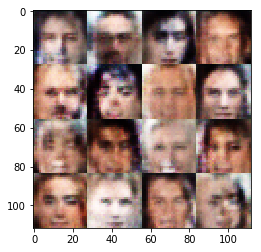

Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.1546


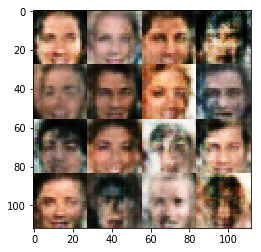

Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.2272
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.4108


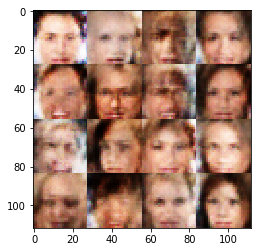

Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 2.1330
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.0628


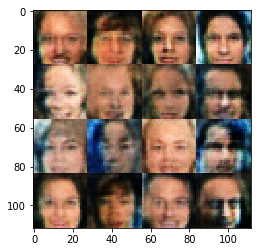

Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.0287


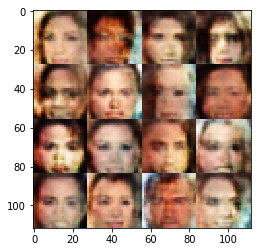

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 1.3463
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7361


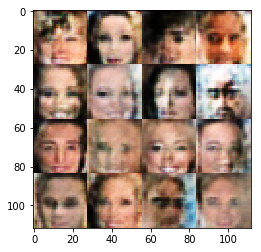

Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7334


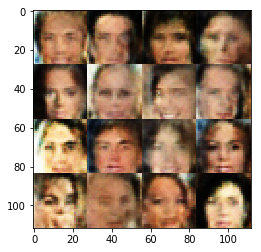

Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 1.1741
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 1.4059


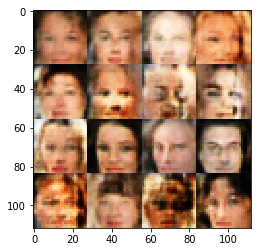

Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.8289


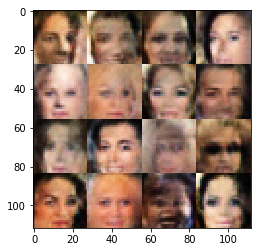

Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.4678
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.0150


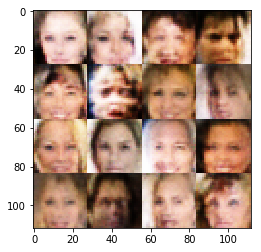

Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.8878
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.8407


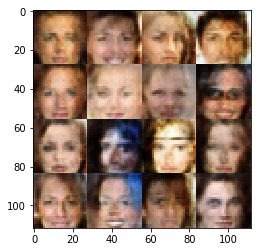

Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9876
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.9805
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.2830


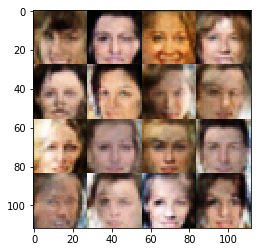

Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 1.2812
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.9704
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6978
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.7680


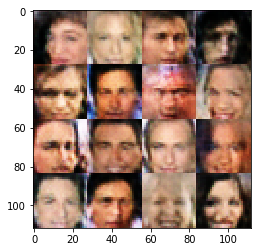

Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.2182
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.6755... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.0263


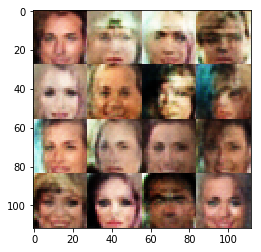

Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.9021
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.1801
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.0530... Generator Loss: 1.1361
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.1922
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 1.6367


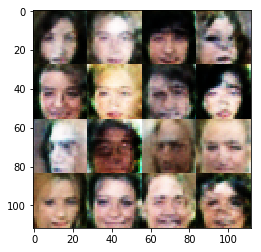

Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.4536
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.8303


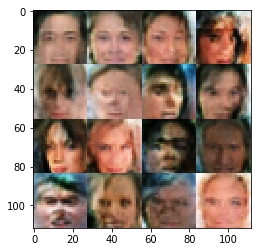

Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.0166
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.1310


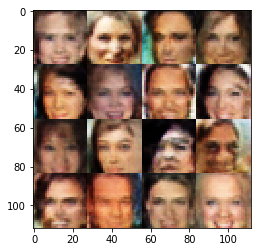

Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.9995
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.0523


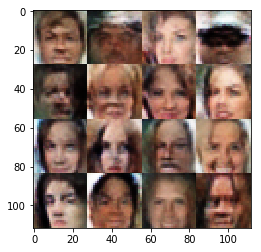

Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 1.1255


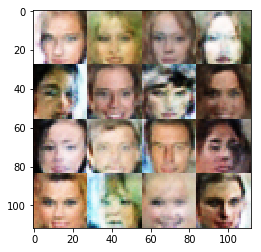

Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.9370
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 1.5142
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6877


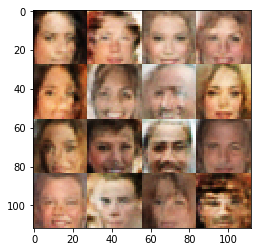

Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6585


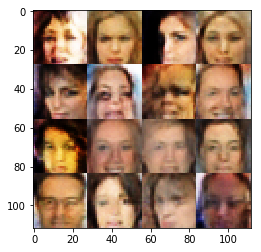

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 0.9650... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.2626
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8809


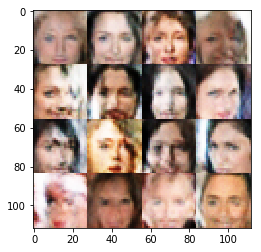

Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.1430... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.9640


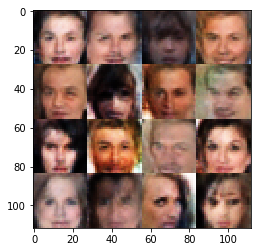

Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 1.3150
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.0927


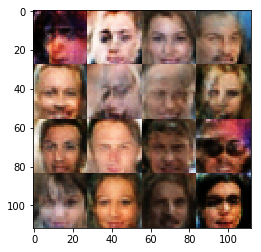

Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.0467... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6239


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.